# Milestone 2 Sentiment Analysis

Description : It this script, it will select the top 10 mentioned stock in reddit, and later perform sentiment analysis for the top 10 mentioned stocks using the comment in reddit.

### 1.0 Import Packages

In [6]:
import numpy as np
import pandas as pd
import nltk
import praw
import os
import warnings
warnings.filterwarnings('ignore')
import time
import matplotlib.pyplot as plt
import squarify
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import date

### 2.0 Download Vader Lexicon - lexicon and rule base sentiment analysis tools
To understand Vader Lexicon in detail : https://www.kaggle.com/nltkdata/vader-lexicon

In [2]:
cwd = os.getcwd()
# print current path
print(cwd)
nltk.download('vader_lexicon', download_dir=cwd)

/Users/user/Desktop/Milestone2


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/user/Desktop/Milestone2...


True

### 3.0 Only consider US stock with market cap > 100 Million & price > USD 3

In [4]:
# US ticker stocks list is in the same path
stocks = pd.read_csv('tickers.csv')

# Last sale column is an object, let's convert to float
stocks['Last Sale'] = stocks['Last Sale'].str.replace('$','')
stocks['Last Sale'] = pd.to_numeric(stocks['Last Sale'],downcast='float')
type(stocks['Last Sale'][0])

# filter out stocks > usd3 and usd100 million cap
price_filter = stocks['Last Sale'] >= 3.00
cap_filter = stocks['Market Cap'] >= 100000000

# make set of symbols
stocks = set(stocks[(price_filter) & (cap_filter)]['Symbol'])

### 4.0 Consider the Unique Lingo and Terminology used in the Subreddit r/Wallstreetbets.

In [14]:
# Includes common words and words used on wsb that are also stock names
blacklist = {'I', 'ELON', 'WSB', 'THE', 'A', 'ROPE', 'YOLO', 'TOS', 'CEO', 'DD', 'IT', 'OPEN', 'ATH', 'PM', 'IRS', 'FOR','DEC', 'BE', 'IMO', 'ALL', 'RH', 'EV', 'TOS', 'CFO', 'CTO', 'DD', 'BTFD', 'WSB', 'OK', 'PDT', 'RH', 'KYS', 'FD', 'TYS', 'US', 'USA', 'IT', 'ATH', 'RIP', 'BMW', 'GDP', 'OTM', 'ATM', 'ITM', 'IMO', 'LOL', 'AM', 'BE', 'PR', 'PRAY', 'PT', 'FBI', 'SEC', 'GOD', 'NOT', 'POS', 'FOMO', 'TL;DR', 'EDIT', 'STILL', 'WTF', 'RAW', 'PM', 'LMAO', 'LMFAO', 'ROFL', 'EZ', 'RED', 'BEZOS', 'TICK', 'IS', 'PM', 'LPT', 'GOAT', 'FL', 'CA', 'IL', 'MACD', 'HQ', 'OP', 'PS', 'AH', 'TL', 'JAN', 'FEB', 'JUL', 'AUG', 'SEP', 'SEPT', 'OCT', 'NOV', 'FDA', 'IV', 'ER', 'IPO', 'MILF', 'BUT', 'SSN', 'FIFA', 'USD', 'CPU', 'AT', 'GG', 'Mar'}

# Adding wsb/reddit flavor to vader to improve sentiment analysis, score: 4.0 to -4.0
new_words = {
    'citron': -4.0,  
    'hidenburg': -4.0,        
    'moon': 4.0,
    'highs': 2.0,
    'mooning': 4.0,
    'long': 2.0,
    'short': -2.0,
    'call': 4.0,
    'calls': 4.0,    
    'put': -4.0,
    'puts': -4.0,    
    'break': 2.0,
    'tendie': 2.0,
     'tendies': 2.0,
     'town': 2.0,     
     'overvalued': -3.0,
     'undervalued': 3.0,
     'buy': 4.0,
     'sell': -4.0,
     'gone': -1.0,
     'gtfo': -1.7,
     'paper': -1.7,
     'bullish': 3.7,
     'bearish': -3.7,
     'bagholder': -1.7,
     'stonk': 1.9,
     'green': 1.9,
     'money': 1.2,
     'print': 2.2,
     'rocket': 2.2,
     'bull': 2.9,
     'bear': -2.9,
     'pumping': -1.0,
     'sus': -3.0,
     'offering': -2.3,
     'rip': -4.0,
     'downgrade': -3.0,
     'upgrade': 3.0,     
     'maintain': 1.0,          
     'pump': 1.9,
     'hot': 1.5,
     'drop': -2.5,
     'rebound': 1.5,  
     'crack': 2.5,}

### 5.0 Start Sentiment Analysis
it may take few minutes to complete the analysis.
In this analysis, it use "praw" to accewss the Reddit forum. "Praw" is a open source python api for Reddit.
For more detail, you may refer to the following link:
https://praw.readthedocs.io/en/stable/

In [7]:
print("Running sentiment analysis, this may take a few minutes...\n")

# Instantiate praw object
start_time = time.time()
reddit = praw.Reddit(user_agent="Comment Extraction", client_id = "QktIf3FZ10C5jg" , client_secret= "52XN7-d-s7tBO8Wld9mPQ19PMaV8HA")

Running sentiment analysis, this may take a few minutes...



Version 7.0.0 of praw is outdated. Version 7.4.0 was released Friday July 30, 2021.


In [11]:
# Set program parameters
subs = ['wallstreetbets', 'stocks', 'investing', 'stockmarket']     # sub-reddit to search
post_flairs = {'Daily Discussion', 'Weekend Discussion', 'Discussion'}    # posts flairs to search || None flair is automatically considered
goodAuth = {'AutoModerator'}   # authors whom comments are allowed more than once
uniqueCmt = True                # allow one comment per author per symbol
ignoreAuthP = {'example'}       # authors to ignore for posts 
ignoreAuthC = {'example'}       # authors to ignore for comment
upvoteRatio = 0.70         # upvote ratio for post to be considered, 0.70 = 70%
ups = 20       # define # of upvotes, post is considered if upvotes exceed this #
limit = 10      # define the limit, comments 'replace more' limit
upvotes = 2     # define # of upvotes, comment is considered if upvotes exceed this #
picks = 10     # define # of picks here, prints as "Top ## picks are:"
picks_ayz = 10   # define # of picks for sentiment analysis

# Define variables
posts, count, c_analyzed, tickers, titles, a_comments = 0, 0, 0, {}, [], {}
cmt_auth = {}

In [15]:
# start web-crawling and do the sentiment analysis
for sub in subs:
    subreddit = reddit.subreddit(sub)
    hot_python = subreddit.hot()
    # Extracting comments, symbols from subreddit
    for submission in hot_python:
        flair = submission.link_flair_text
        author = submission.author #name
        
        #checking: post upvote ratio # of upvotes, post filter, and author
        if submission.upvote_ratio >= upvoteRatio and submission.ups > ups and (flair in post_flairs or flair is None) and author not in ignoreAuthP:
            submission.comment_sort = 'new'
            comments = submission.comments
            titles.append(submission.title)
            posts += 1
            submission.comments.replace_more(limit = limit)
            for comment in comments:
                # try except for deleted account?
                try:
                    auth = comment.author.name
                except:
                    pass
                c_analyzed += 1

                # checking: comment upvotes and author
                if comment.score > upvotes and auth not in ignoreAuthC:
                    split = comment.body.split(' ')
                    for word in split:
                        word = word.replace("$", "")
                        # upper = ticker, length of ticker <= 5, excluded words
                        if word.isupper() and len(word) <= 5 and word not in blacklist and word in stocks:
                            
                            # unique comments, try/except for key errors
                            if uniqueCmt and auth not in goodAuth:
                                try:
                                    if auth in cmt_auth[word]:
                                        break
                                except:
                                    pass
                            
                            # counting tickers
                            if word in tickers:
                                tickers[word] += 1
                                a_comments[word].append(comment.body)
                                cmt_auth[word].append(auth)
                            count += 1
                            else:
                                tickers[word] = 1
                                cmt_auth[word] = [auth]
                                a_comments[word] = [comment.body]
                                count += 1

In [33]:
# sorts the dictionary
symbols = dict(sorted(tickers.items(), key=lambda item: item[1], reverse = True))
top_picks = list(symbols.keys())[0:picks]
time = (time.time() - start_time)

In [35]:
# print top picks
print("It took {t:.2f} seconds to analyze {c} comments in {p} posts in {s} subreddits.\n".format(t=time,
                                                                                                c=c_analyzed,
                                                                                                p=posts,
                                                                                                s=len(subs)))
print("Posts analyzed saved in titles")
# for i in titles: print(i) # prints the title of the posts analyzed

print(f"\n{picks} most mentioned picks: ")
times = []
top = []
for i in top_picks:
    #print(f"{i}: {symbols[i]}")
    times.append(symbols[i])
    top.append(f"{i}: {symbols[i]}")
#print(' '.join(map(str, top)))
top_10 = '''{} \n{} \n{} \n{} \n{} \n{} \n{} \n{} \n{} \n{}
'''.format(top[0],top[1],top[2],top[3],top[4],top[5],top[6],top[7],top[8],top[9])
print(top_10)

It took 66893.08 seconds to analyze 4377 comments in 82 posts in 4 subreddits.

Posts analyzed saved in titles

10 most mentioned picks: 
AAPL: 11 
AMD: 11 
INTC: 9 
NVDA: 8 
ASML: 7 
TSLA: 5 
MU: 4 
MSFT: 4 
AMZN: 3 
ON: 2



In [37]:
# Applying sentiment analysis
scores, s = {}, {}

vader = SentimentIntensityAnalyzer()
# adding custom words from data.py
vader.lexicon.update(new_words)

picks_sentiment = list(symbols.keys())[0: picks_ayz]
for symbol in picks_sentiment:
    stock_comments = a_comments[symbol]
    for cmnt in stock_comments:
        score = vader.polarity_scores(cmnt)
        if symbol in s:
            s[symbol][cmnt] = score
        else:
            s[symbol] = {cmnt: score}
        if symbol in scores:
            for key, _ in score.items():
                scores[symbol][key] += score[key]
        else:
            scores[symbol] = score

    # calculating averages
    for key in score:
        scores[symbol][key] = scores[symbol][key] / symbols[symbol]
        scores[symbol][key] = "{pol:.3f}".format(pol=scores[symbol][key])

# Printing sentiment analysis
print(f"\nSentiment analysis of top {picks_ayz} picks:")
df = pd.DataFrame(scores)
df.index = ['Bearish', 'Neutral', 'Bullish', 'Total_Compound']
df = df.T
print(df)


Sentiment analysis of top 10 picks:
     Bearish Neutral Bullish Total_Compound
AAPL   0.110   0.733   0.157          0.258
AMD    0.032   0.825   0.142          0.523
INTC   0.079   0.763   0.159          0.361
NVDA   0.009   0.887   0.104          0.065
ASML   0.020   0.852   0.128          0.419
TSLA   0.016   0.884   0.100          0.341
MU     0.022   0.926   0.052          0.371
MSFT   0.017   0.900   0.083          0.372
AMZN   0.027   0.840   0.133          0.417
ON     0.122   0.806   0.071         -0.065


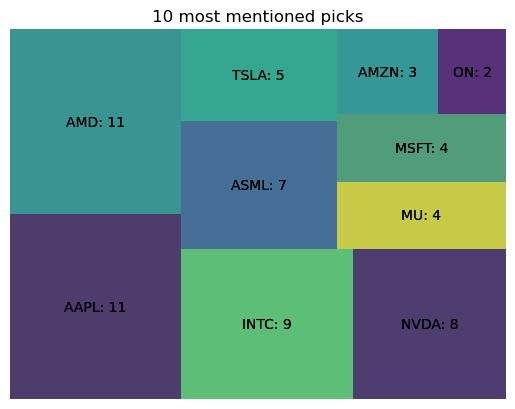

In [42]:
# Data Visualization
# Most mentioned picks
squarify.plot(sizes=times, label=top, alpha=0.7)
plt.axis('off')
plt.title(f"{picks} most mentioned picks")
plt.show()

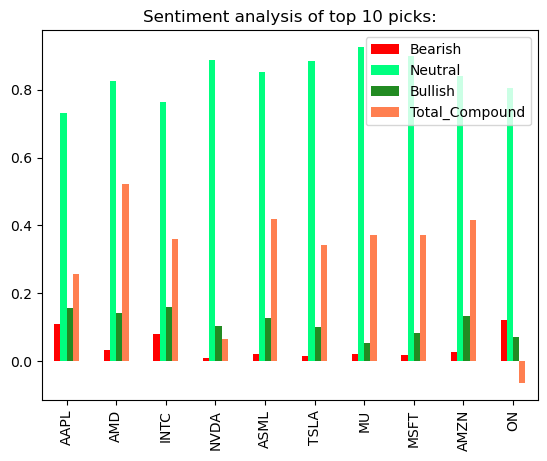

In [43]:
# Sentiment analysis
df = df.astype(float)
colors = ['red', 'springgreen', 'forestgreen', 'coral']
df.plot(kind='bar', color=colors, title=f"Sentiment analysis of top {picks_ayz} picks:")
fig = plt.gcf()
plt.show()
fig.savefig('SentimentAnalyzer.png')

In [44]:
# append date column to dataframe for storing in database
df['date'] = [date.today() for x in range(df.shape[0])]
df.reset_index(inplace=True)
df.rename(columns={'index': 'stock'}, inplace=True)

# Save current top wsb stocks to csv file
df.to_csv('df.csv')